In [81]:
import scipy.io
data = scipy.io.loadmat('data.mat')

import numpy as np
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Bias5', 'Bias_avg', 'DR_event_idx', 'K', 'MAPE5', 'MAPE_avg', 'NARE5', 'NARE_avg', 'customer', 'days', 'event_period', 'flag', 'i', 'test5'])


In [82]:
data['customer'][0][0][1][0][0]
# [customer]表示数据集的名称
# 第二个[]表示custmoer底下的内容，由于只有一份，故为0
# 第三个[]表示选取的行数,即为选取哪个用户
# 第四个[0]内容为选取用户的id，[1]表示用户数据
# 第五个[]表示选取结构体的行数,即为单个用户的表示的小时数
# 第六个[]表示列数，即为天数(171)

0.213

In [83]:
# 制作单个用户的数据集，以id:1002用户为例
dataset_1002 = []
id = 3000   # 用户id
for i in range(171):
    for j in range(24):
        dataset_1002.append(data['customer'][0][id-1002][1][j][i])
dataset_1002 = np.array(dataset_1002, dtype=np.float32)
print(dataset_1002.shape)

(4104,)


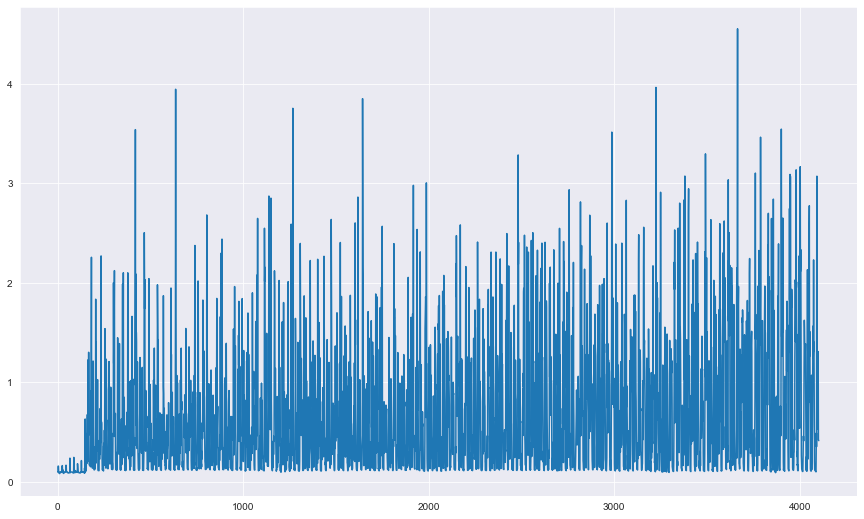

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

# scaler = MinMaxScaler(feature_range=(0,1))
# dataset_1002 = scaler.fit_transform(dataset_1002)
sns.set_style("darkgrid")
plt.figure(figsize=(15,9))
plt.plot(dataset_1002)
plt.show()

In [85]:
# 进行数据集的划分
def split_data(stock, lookback):
    data = []
    
    for index in range(len(stock)-lookback):
        # data.append(stock[index:index + lookback])
        for i in range(16):
            data.append(stock[index + i*24])
    
    data = np.array(data, dtype=np.float32)
    data = scale(data, with_mean=False, with_std=False)
    print(data.shape)
    
    test_set_size = int(np.round(0.3 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = np.array(data[:train_set_size,:-25], dtype=np.float32)
    y_train = np.array(data[:train_set_size, -1], dtype=np.float32)
    
    x_test = np.array(data[train_set_size:,:-25], dtype=np.float32)
    y_test = np.array(data[train_set_size:,-1], dtype=np.float32)
    return x_train, y_train, x_test, y_test

In [86]:
# 选取前十四天同一时刻的负载数值，故为 24 * 16 (第十五天预测第十六天)
x_train, y_train, x_test, y_test = split_data(dataset_1002, 24*16)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(3767, 337)
(2637, 312)
(2637,)
(1130, 312)
(1130,)


In [87]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch.utils.data as Data


#将数据集转化为张量 并处理为PyTorch网络使用的数据
train_xt=torch.from_numpy(x_train.astype(np.float32))
train_yt=torch.from_numpy(y_train.astype(np.float32))
test_xt=torch.from_numpy(x_test.astype(np.float32))
test_yt=torch.from_numpy(y_test.astype(np.float32))
#将数据处理为数据加载器
train_data=Data.TensorDataset(train_xt,train_yt)
test_data=Data.TensorDataset(test_xt,test_yt)
train_loader=Data.DataLoader(dataset=train_data,batch_size=5,shuffle=True,num_workers=0)

In [88]:
#搭建MLP回归模型
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression,self).__init__()
        #定义第一个隐藏层
        self.hidden1=nn.Linear(in_features=312 ,out_features=20,bias=True)#8*100 8个属性特征
        # #定义第二个隐藏层
        # self.hidden2=nn.Linear(100,100)#100*100
        # #定义第三个隐藏层
        # self.hidden3=nn.Linear(100,50)#100*50
        #回归预测层
        self.predict=nn.Linear(20,1)#50*1  预测只有一个 房价
    def forward(self,x):
        sigmoid = nn.Sigmoid()
        x=sigmoid(self.hidden1(x))
        # x=F.relu(self.hidden2(x))
        # x=F.relu(self.hidden3(x))
        output=self.predict(x)
        return output[:,0]
mlpreg=MLPregression()
print(mlpreg)

MLPregression(
  (hidden1): Linear(in_features=312, out_features=20, bias=True)
  (predict): Linear(in_features=20, out_features=1, bias=True)
)


Epoch: 0 Loss: 0.2532171440112292
Epoch: 1 Loss: 0.2159667008081935
Epoch: 2 Loss: 0.20360206742550235
Epoch: 3 Loss: 0.20045814265885167
Epoch: 4 Loss: 0.19369439064958766
Epoch: 5 Loss: 0.19019937539808868
Epoch: 6 Loss: 0.18405027406016108
Epoch: 7 Loss: 0.1776818298865576
Epoch: 8 Loss: 0.17231576723277667
Epoch: 9 Loss: 0.1671787208537043
Epoch: 10 Loss: 0.16059166185578502
Epoch: 11 Loss: 0.15635509159305416
Epoch: 12 Loss: 0.14691881494708556
Epoch: 13 Loss: 0.14209264406065922
Epoch: 14 Loss: 0.13776059217486497
Epoch: 15 Loss: 0.12922054366941452
Epoch: 16 Loss: 0.12525437429085004
Epoch: 17 Loss: 0.12089842691773688
Epoch: 18 Loss: 0.11693119200191626
Epoch: 19 Loss: 0.10873175954138405
Epoch: 20 Loss: 0.10387844842513207
Epoch: 21 Loss: 0.10143603470051435
Epoch: 22 Loss: 0.09513643140191898
Epoch: 23 Loss: 0.09525257243315616
Epoch: 24 Loss: 0.08889240237933138
Epoch: 25 Loss: 0.08392157490679268
Epoch: 26 Loss: 0.08100742566957558
Epoch: 27 Loss: 0.07811410056061938
Epoch:

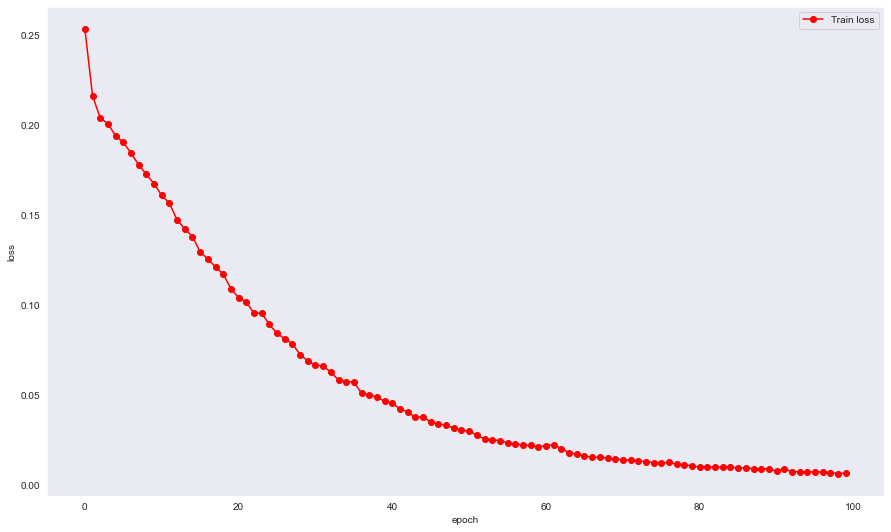

In [89]:
#定义优化器
optimizer=torch.optim.SGD(mlpreg.parameters(),lr=0.1)
loss_func=nn.MSELoss()
train_loss_all=[]
for epoch in range(100):
    train_loss=0
    train_num=0
    for step,(b_x,b_y) in enumerate(train_loader):
        output=mlpreg(b_x)
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*b_x.size(0)
        train_num+=b_x.size(0)
    print("Epoch:",epoch,"Loss:",train_loss/train_num)
    train_loss_all.append(train_loss/train_num)
plt.figure(figsize=(15,9))
plt.plot(train_loss_all,"ro-",label="Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

1130
RMSE is tensor(0.5789)
NRMSE is 0.6443069992666901


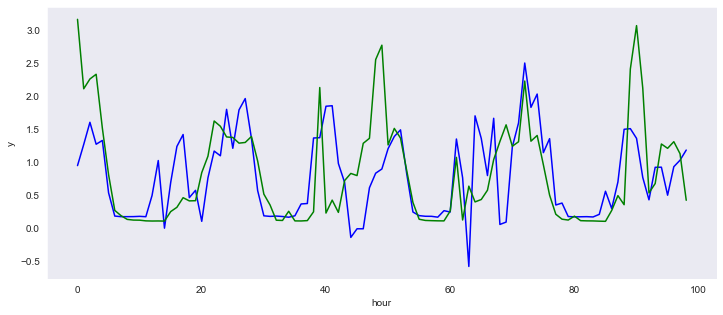

In [90]:
#预测
import math

pre_y=mlpreg(test_xt)
pre_y=pre_y.data.numpy()
test_yt = test_yt
print(len(pre_y))
# mae=mean_absolute_error(y_test,pre_y)
MAE,S1,RMSE,S2 = 0,0,0,0
for index in range(len(pre_y)):
    MAE += abs(pre_y[index]-test_yt[index])
    RMSE += (pre_y[index]-test_yt[index])**2
    S1 += abs(test_yt[index])
    S2 += test_yt[index]**2
    
NMAE = MAE/S1
NRMSE = math.sqrt(RMSE/S2)
print("RMSE is", NMAE)
print("NRMSE is", NRMSE)

# index=np.argsort(y_test)
plt.figure(figsize=(12,5))
plt.plot(pre_y[-100:-1],"b")
plt.plot(test_yt[-100:-1],"g")
# plt.plot(np.arange(len(y_test)),y_test[index],"r",label="original y")
# plt.scatter(np.arange(len(pre_y)),pre_y[index],s=3,c="b",label="prediction")
# plt.legend(loc="upper left")
plt.grid()
plt.xlabel("hour")
plt.ylabel("y")
plt.show()
